# Building Makemore - Exercises

Notes on the exercises from the [building makemore video](https://www.youtube.com/watch?v=PaCmpygFfXo).<br>
The video description holds the exercises, which are also listed below.<br>
Feel free to try solving on your own first using [this starter notebook](./002%20-%20Makemore_Exercises.ipynb).

1. Watch the [building makemore video](https://www.youtube.com/watch?v=PaCmpygFfXo) on YouTube
2. Come back and complete the exercises to level up :)

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Exercise 1 - Trigram Language Model

**Objective:** Train a trigram language model, i.e. take two characters as an input to predict the 3rd one.<br>
Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

**Intuition:** A trigram model will be able to evaluate its choice for a next character based on more context. This should improve the loss over a bigram model.

In [2]:
# Set training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load dataset -> List[str]
words = open('../names.txt', 'r').read().splitlines()

Each trigram is a sequence of $2$ input characters, followed by $1$ expected output character.<br>
The model will predict the output character given the two input characters.<br>

We can cheekily modify the bigram sliding-window approach to accomodate for trigrams:

In [3]:
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # Three char 'sliding-window'
        print(ch1, ch2, ch3)

. e m
e m m
m m a
m a .


Note how the first trigram is of shape `('.', 'e', 'm')`, and not of shape `('.', '.', 'e')`.<br>
You could in fact modify the code to produce the latter though `chs = ['.', '.'] + list(w) + ['.', '.']`.<br>
The thing is, the first two characters being special tokens means they can't reliably indicate any next character.<br>
Therefore, excluding them from the trigram is a good idea to avoid confusion and wasted computation.

To visualize the trigrams, we have $26$ letters **+1** special character.<br>
This makes for a $27\times 27\times 27$ total combinations array.

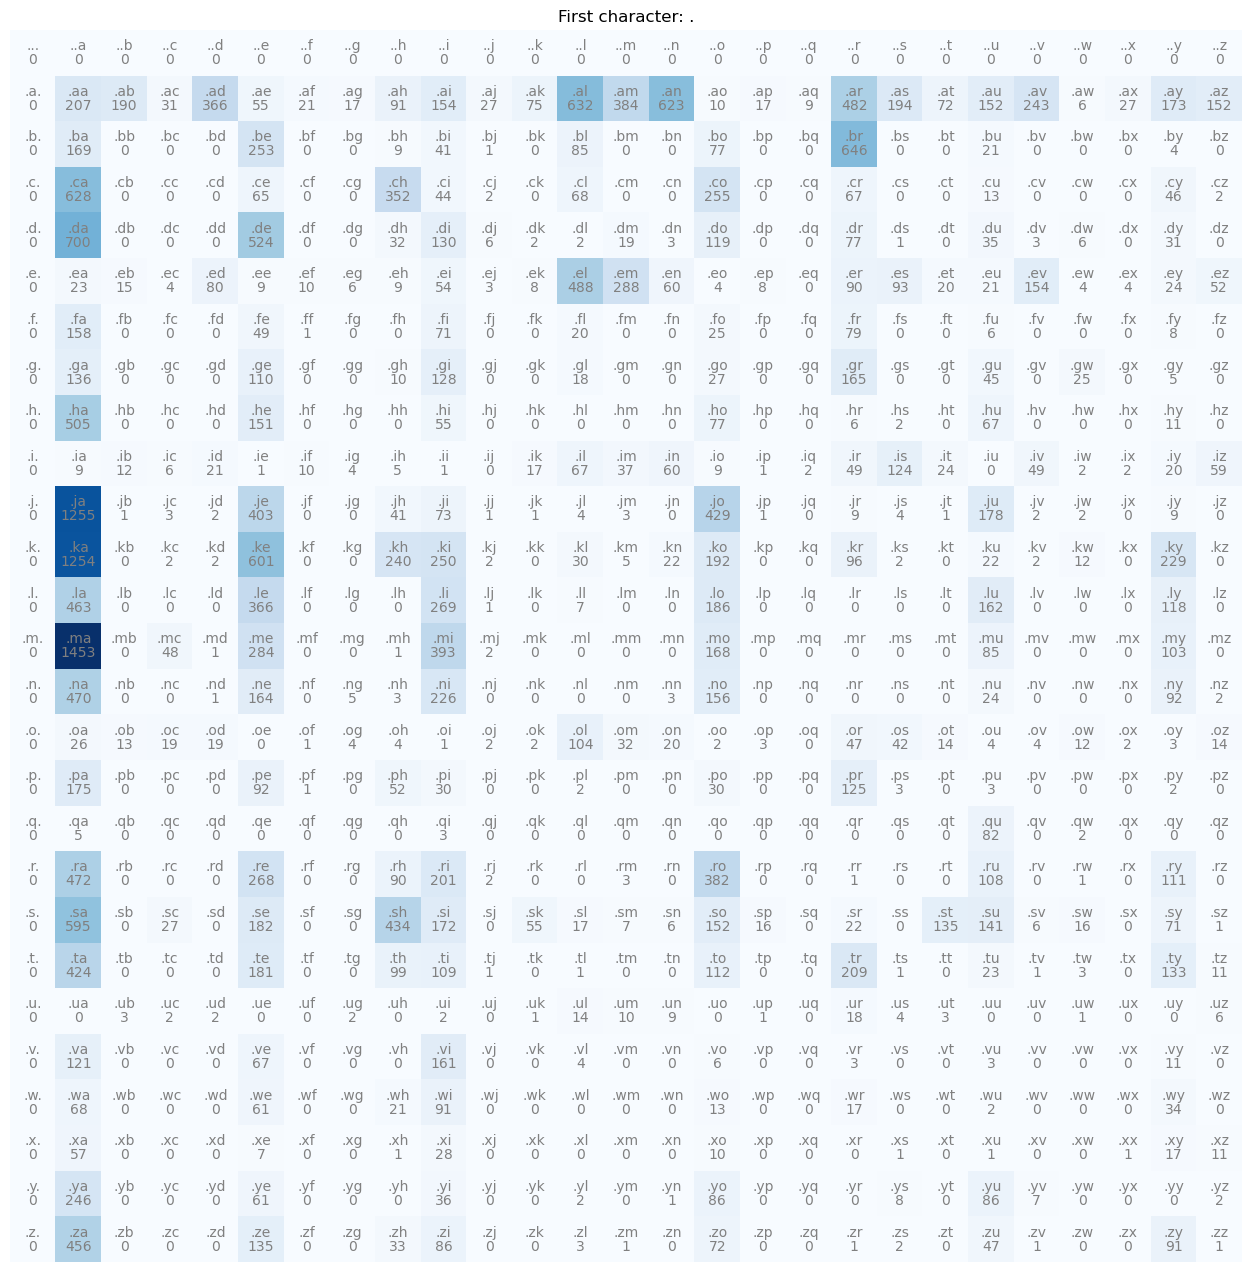

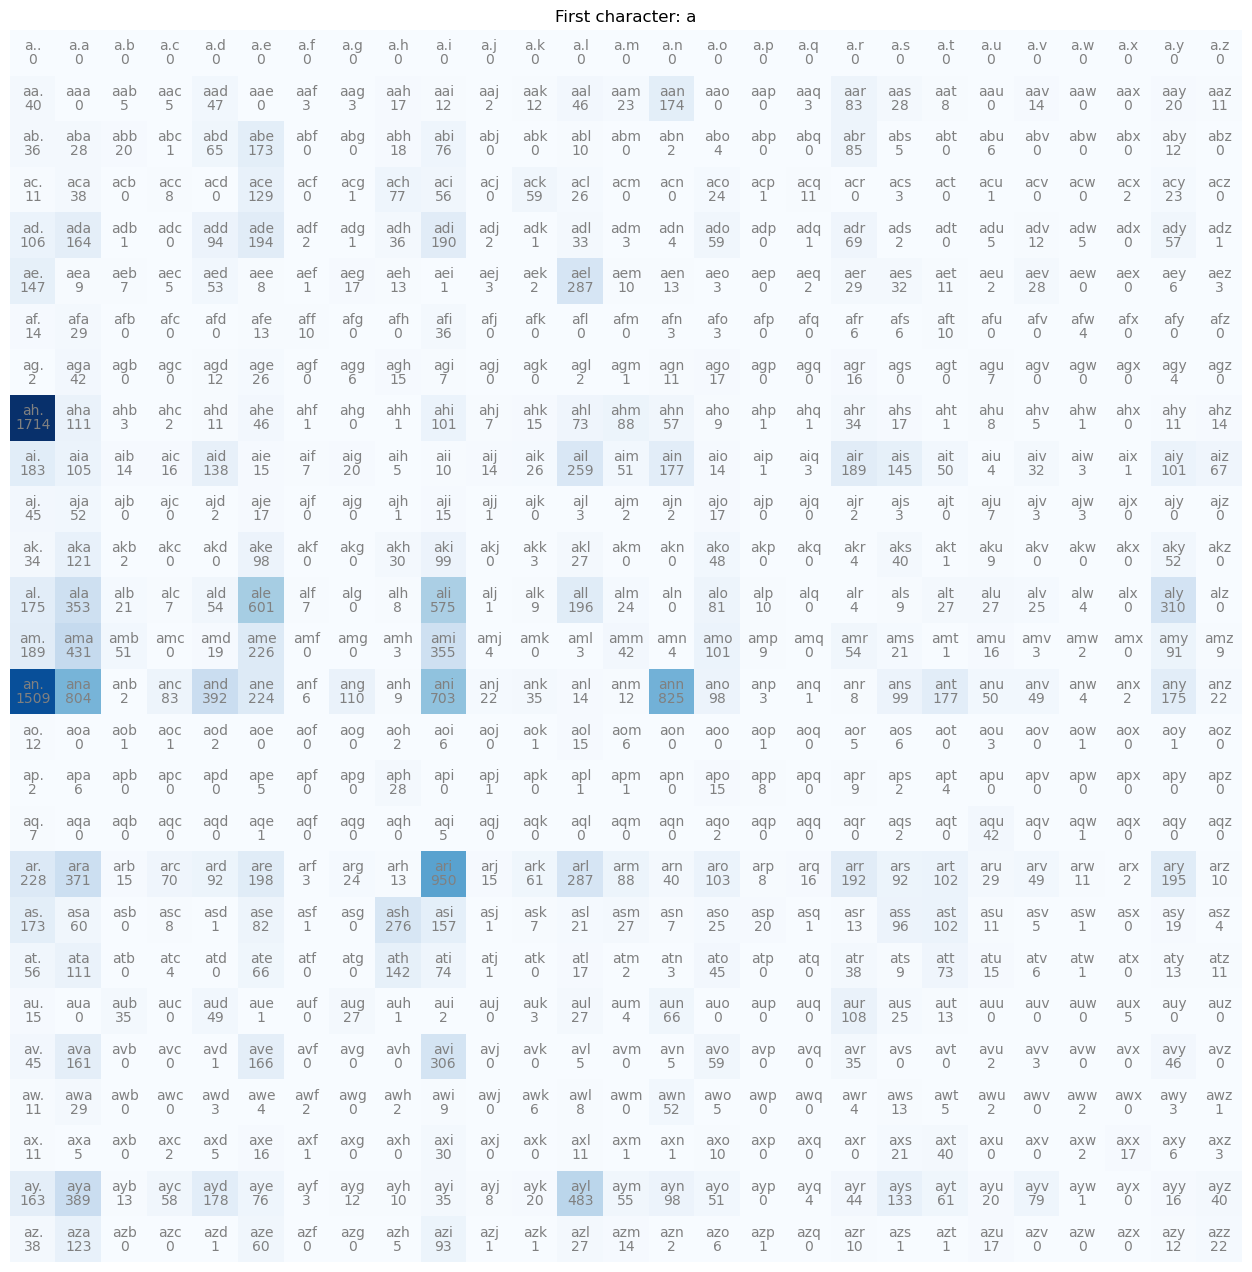

In [7]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Special token has position zero
itos = {i:s for s,i in stoi.items()}

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # Three token 'sliding-window'
        N[stoi[ch1], stoi[ch2], stoi[ch3]] += 1 # Increment cell in 3D tensor by 1

# You can create 27 separate 2D heatmaps, one for each first character
# I will just create 2 for presentation purposes
for k in range(2): # 27
    plt.figure(figsize=(16, 16))
    plt.imshow(N[k], cmap='Blues')
    plt.title(f"First character: {itos[k]}")
    for i in range(27):
        for j in range(27):
            chstr = itos[k] + itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[k,i,j].item(), ha="center", va="top", color="gray")
    plt.axis('off')
    plt.show()

I will go on and implement the neural network version of the trigram model.<br>
The biggest change in the below code is the dealing with two input characters at once.

In [8]:
# Create training set of all trigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()
print('number of examples\nx:', num_x, '\ny:', num_y)

number of examples
x: 196113 
y: 196113


Each character can be represented by a $27$-dimensional one-hot vector.<br>
The one-hot vector to the two input characters therefore is a $27+27=54$-dimensional input vector.<br>
You can think of this 54-dimensional vector as a sort of two-hot vector, where two of the $54$ dimensions are $1$ and the rest are $0$:

In [61]:
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

In [62]:
# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
for k in range(200):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
    xenc = xenc.view(num_x, -1) # concatenate the one-hot vectors, [196113, 54]
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(num_x), ys].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.195971965789795
Loss @ iteration 2: 3.3653788566589355
Loss @ iteration 3: 3.049534320831299
Loss @ iteration 4: 2.878479480743408
Loss @ iteration 5: 2.7739577293395996
Loss @ iteration 6: 2.7012393474578857
Loss @ iteration 7: 2.6454999446868896
Loss @ iteration 8: 2.6012837886810303
Loss @ iteration 9: 2.5652341842651367
Loss @ iteration 10: 2.535409688949585
Loss @ iteration 11: 2.510397434234619
Loss @ iteration 12: 2.4892261028289795
Loss @ iteration 13: 2.4711146354675293
Loss @ iteration 14: 2.455474853515625
Loss @ iteration 15: 2.4418275356292725
Loss @ iteration 16: 2.4298086166381836
Loss @ iteration 17: 2.4191300868988037
Loss @ iteration 18: 2.4095730781555176
Loss @ iteration 19: 2.400963068008423
Loss @ iteration 20: 2.3931643962860107
Loss @ iteration 21: 2.386066198348999
Loss @ iteration 22: 2.3795783519744873
Loss @ iteration 23: 2.373626470565796
Loss @ iteration 24: 2.368147373199463
Loss @ iteration 25: 2.3630881309509277
Loss @ iteration 26

The bigram model had produced a loss of $2.462393045425415$.<br>
The trigram model produces a loss of $2.259373664855957$, which marks an $8.24\%$ improvement.

## Exercise 2 - Splitting the Dataset, Evaluation on Dev and Test Sets

**Objective:** Split up the dataset randomly into $80\%$ train set, $10\%$ dev set, $10\%$ test set.<br>
Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [5]:
g = torch.Generator(device=device).manual_seed(2147483647)

### Baselining with the bigram model

We use the bigram model code we built in the video to establish a baseline.

In [9]:
# Create set of all *bigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113], [196113]
num_x, num_y = xs.nelement(), ys.nelement()

# Shuffle/Permute the dataset, keeping pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm], ys[perm]

# Split 80:10:10 for train:valid:test
xs_bi_train, xs_bi_valid, xs_bi_test = xs[:int(num_x * 0.8)], xs[int(num_x * 0.8):int(num_x * 0.9)], xs[int(num_x * 0.9):]
ys_bi_train, ys_bi_valid, ys_bi_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

In [10]:
W = torch.randn((27,27), device=device, generator=g, requires_grad=True)

# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):    
    # Forward pass
    xenc = F.one_hot(xs_bi_train, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 3.768343925476074
Loss @ iteration 2: 3.3780953884124756
Loss @ iteration 3: 3.1608059406280518
Loss @ iteration 4: 3.0273096561431885
Loss @ iteration 5: 2.934847593307495
Loss @ iteration 6: 2.8677432537078857
Loss @ iteration 7: 2.817232131958008
Loss @ iteration 8: 2.7777299880981445
Loss @ iteration 9: 2.7458078861236572
Loss @ iteration 10: 2.719336986541748
Loss @ iteration 11: 2.6969549655914307
Loss @ iteration 12: 2.6777608394622803
Loss @ iteration 13: 2.661130905151367
Loss @ iteration 14: 2.6466152667999268
Loss @ iteration 15: 2.6338698863983154
Loss @ iteration 16: 2.6226205825805664
Loss @ iteration 17: 2.6126458644866943
Loss @ iteration 18: 2.6037588119506836
Loss @ iteration 19: 2.595803737640381
Loss @ iteration 20: 2.588650941848755
Loss @ iteration 21: 2.58219051361084
Loss @ iteration 22: 2.576331615447998
Loss @ iteration 23: 2.570995330810547
Loss @ iteration 24: 2.566117525100708
Loss @ iteration 25: 2.5616424083709717
Loss @ iteration 26: 

The training set informs the bigram model to a degree where it reaches a loss of $2.4826600551605225$.<br>
That's slightly worse than before, but we trained on less data.<br>
More importantly, as we held back some data, we can measure the generalization of the model on the dev and test sets.

In [14]:
# Validation Loss
with torch.no_grad():
    xenc = F.one_hot(xs_bi_valid, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_valid].log().mean() + 0.01 * (W**2).mean()
print(f'Validation Loss: {loss}')

# Test Loss
with torch.no_grad():
    xenc = F.one_hot(xs_bi_test, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_test].log().mean() + 0.01 * (W**2).mean()
print(f'Test Loss:\t {loss}')

Validation Loss: 2.4916939735412598
Test Loss:	 2.479123830795288


The train, validation and test loss are all very close to each other, indicating that the bigram model generalizes well to the unseen data.<br>
In other words, complexities faced by the model during training enable to perform well on unseen data.

### Comparing the bigram and trigram models

**Intuition:** Will the trigram model generalize as well as the bigram model?<br>
I'd deem this unlikely. There are $27^3=19683$ possible trigrams. Compare that to the $27^2=729$ possible bigrams.<br>
This is a sizable difference in possible combinations the model can encounter. Also, the learnable weight space `W` of the trigram model is larger than that of the bigram model to accomodate. Learning the trigram model implies a higher-dimensional optimization problem, which considers more of each name's structure, but is also harder to solve.<br>
Therefore generalizing to unseen data will be harder. Both validation and test loss will likely be higher than the training loss.

In [22]:
# Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()

# Shuffle/Permute the dataset, keeping (x,y) pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm,:], ys[perm] # xs are shuffled along the zeroth dimension

# Split 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(num_x * 0.8),:], xs[int(num_x * 0.8):int(num_x * 0.9),:], xs[int(num_x * 0.9):,:]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

torch.Size([156890, 2])


In [25]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
    xenc = xenc.view(d_size, -1) # concatenate the one-hot vectors, [196113, 54]
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.185319423675537
Loss @ iteration 2: 3.42909836769104
Loss @ iteration 3: 3.086361885070801
Loss @ iteration 4: 2.8972339630126953
Loss @ iteration 5: 2.7765438556671143
Loss @ iteration 6: 2.6953940391540527
Loss @ iteration 7: 2.6359992027282715
Loss @ iteration 8: 2.5903496742248535
Loss @ iteration 9: 2.5538201332092285
Loss @ iteration 10: 2.524009943008423
Loss @ iteration 11: 2.4991815090179443
Loss @ iteration 12: 2.478286027908325
Loss @ iteration 13: 2.460453987121582
Loss @ iteration 14: 2.445115089416504
Loss @ iteration 15: 2.431779146194458
Loss @ iteration 16: 2.4201040267944336
Loss @ iteration 17: 2.409794330596924
Loss @ iteration 18: 2.400634288787842
Loss @ iteration 19: 2.3924381732940674
Loss @ iteration 20: 2.385064125061035
Loss @ iteration 21: 2.3783912658691406
Loss @ iteration 22: 2.3723244667053223
Loss @ iteration 23: 2.3667819499969482
Loss @ iteration 24: 2.3616995811462402
Loss @ iteration 25: 2.3570196628570557
Loss @ iteration 26: 

The training loss of this trigram model is pretty much identical to its full-dataset counterpart, at $2.2590503692626953$ vs. the original $2.259373664855957$.

In [27]:
# Validation Loss
d_size = xs_tri_valid.shape[0]
with torch.no_grad():
    xenc = F.one_hot(xs_tri_valid, num_classes=27).float().to(device) # one-hot encode the names
    xenc = xenc.view(d_size, -1)
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_valid].log().mean() + 0.01 * (W**2).mean()
print(f'Validation Loss: {loss}')

# Test Loss
d_size = xs_tri_test.shape[0]
with torch.no_grad():
    xenc = F.one_hot(xs_tri_test, num_classes=27).float().to(device) # one-hot encode the names
    xenc = xenc.view(d_size, -1)
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_test].log().mean() + 0.01 * (W**2).mean()
print(f'Test Loss:\t {loss}')

Validation Loss: 2.2693099975585938
Test Loss:	 2.2643346786499023


Both the validation and test loss are higher than the training loss, as expected.<br>
However, they only differ by a small margin, which leaves us with a good sign for the trigram model's generalization.<br>
However, we can intuitively see how the increase in model complexity can affect the generalization of the model.<br>
Still, in this particular case, the additional context provided by the trigram model seems to be quite beneficial for the generalization,<br>
as the loss is only ever so slightly higher than the training loss.

## Exercise 3 - Tuning the Strength of Smoothing

**Objective:** Use the *dev set* to tune the strength of smoothing (or regularization) for the trigram model - i.e.<br>
try many possibilities and see which one works best based on the dev set loss.<br>
What patterns can you see in the train and dev set loss as you tune this strength?<br>
Take the best setting of the smoothing and evaluate on the test set once and at the end.<br>
How good of a loss do you achieve?

Let's start with creating the datasets again.<br>
We will implement a hyperparameter tuning setup to iterate over multiple strength values and visualize their associated train and validation losses.

In [56]:
# Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()

# Shuffle/Permute the dataset, keeping (x,y) pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm,:], ys[perm] # xs are shuffled along the zeroth dimension

# Split 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(num_x * 0.8),:], xs[int(num_x * 0.8):int(num_x * 0.9),:], xs[int(num_x * 0.9):,:]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

For our purposes, covering the hyperparameter space from $0.0$ to $1.0$ with $25$ steps should be sufficient.<br>
For each strength, we train and evaluate a separate trigram model, and store the losses in a list.<br>
In the end, the losses are visualized and the best strength value can be selected.

In [58]:
# from 0.0 to 1.0 in 25 steps
strengths = torch.linspace(0.0, 1.0, 25, device=device)
losst, lossv, lossf = [], [], []

for strength in tqdm(strengths, desc='Training Strengths'):
    W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

    # Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
    d_size = xs_tri_train.shape[0]
    for k in range(200):
        # Forward pass
        xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
        xenc = xenc.view(d_size, -1) # concatenate the one-hot vectors, [196113, 54]
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_t = -probs[torch.arange(d_size), ys_tri_train].log().mean() + strength * (W**2).mean()
        
        # Backward pass
        W.grad = None # Make sure all gradients are reset
        loss_t.backward() # Torch kept track of what this variable is, kinda cool
        
        # Weight update
        W.data += -50 * W.grad

    # Validation Loss
    d_size = xs_tri_valid.shape[0]
    with torch.no_grad():
        xenc = F.one_hot(xs_tri_valid, num_classes=27).float().to(device) # one-hot encode the names
        xenc = xenc.view(d_size, -1)
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_v = -probs[torch.arange(d_size), ys_tri_valid].log().mean() + strength * (W**2).mean()

    # Test Loss
    d_size = xs_tri_test.shape[0]
    with torch.no_grad():
        xenc = F.one_hot(xs_tri_test, num_classes=27).float().to(device) # one-hot encode the names
        xenc = xenc.view(d_size, -1)
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_f = -probs[torch.arange(d_size), ys_tri_test].log().mean() + strength * (W**2).mean()

    # Note the losses for this strength
    losst.append((strength, loss_t))
    lossv.append((strength, loss_v))
    lossf.append((strength, loss_f))

Training Strengths: 100%|██████████| 25/25 [18:53<00:00, 45.36s/it]


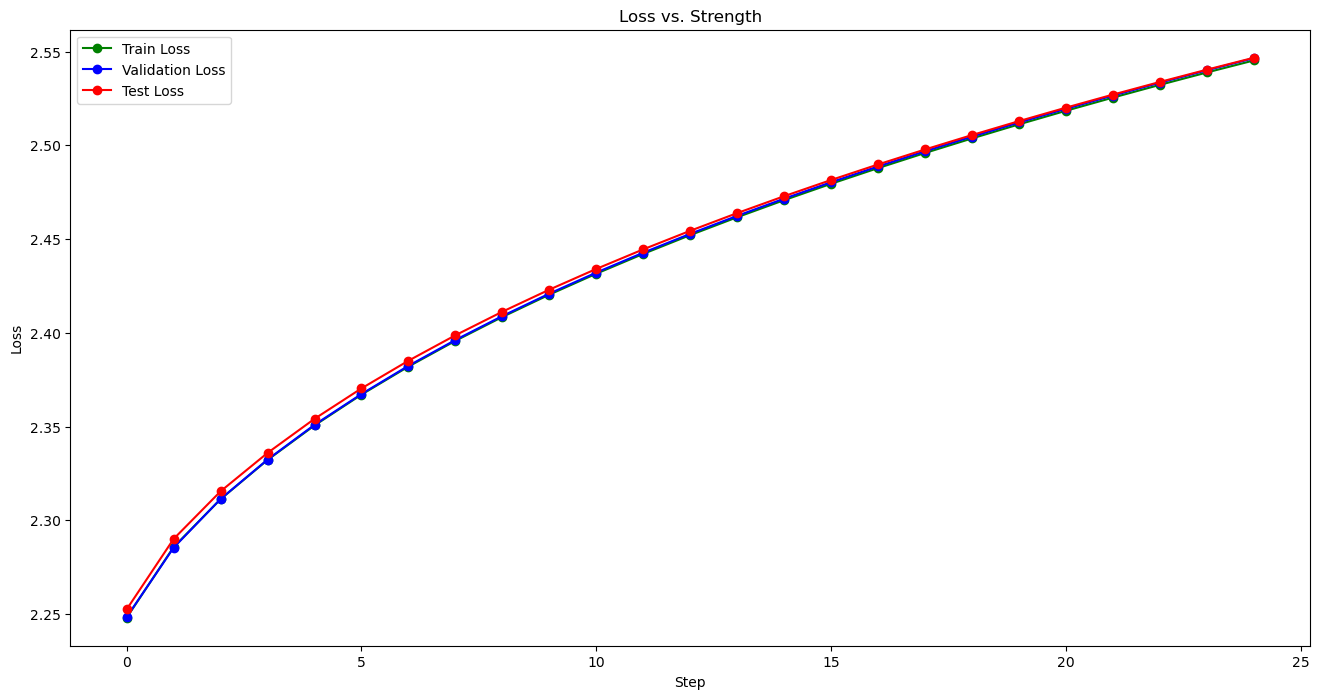

Best Strength: 0.0 @ Train: 2.248020887374878, Validation: 2.248354911804199 & Test: 2.252450466156006


In [59]:
# Plot the losses
plt.figure(figsize=(16, 8))
plt.plot([y.item() for (_, y) in losst], label='Train Loss', linestyle='-', marker='o', color='green')
plt.plot([y.item() for (_, y) in lossv], label='Validation Loss', linestyle='-', marker='o', color='blue')
plt.plot([y.item() for (_, y) in lossf], label='Test Loss', linestyle='-', marker='o', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Strength')
plt.legend()
plt.show()

# Report the best strength
print(f'Best Strength: {min(lossv, key=lambda x: x[1])[0]} @ Train: {min(losst, key=lambda x: x[1])[1]}, Validation: {min(lossv, key=lambda x: x[1])[1]} & Test: {min(lossf, key=lambda x: x[1])[1]}')

The losses across the strengths for regularization indicate a clear trend.<br>
The training loss increases steadily as the regularization strength increases, resembling a logarithmic curve. The validation loss also increases alongside the training loss, and follows the training loss curve closely. The higher the training and validation loss, the closer the test loss will be to both of them. Between smaller regularization strengths, the test loss increases a little more sharply than both training and validation loss.

I am aware that our objective was to tune the strength by evaluating on the dev/val set only.<br>
However, putting the tuning results into the overall context of one another serves as a good indicator of the model's generalization capabilities and what is actually learned.<br>
Regularization penalizes extreme weights in the model. As this penalty is increased, the model is forced to reduce the magnitudes of its weights $W$. This reaction, in our case, seems to compromise the model's capability to learn most effectively. The more we regularize, the higher the loss across all data splits.<br>
The lower the regularization strength, the stronger the deviations between training and test loss.<br>
Yet overall, turning regularization off entirely seems to be the best choice for this particular model and dataset. The problem space and dataset size with which we operate are seemingly too small to benefit from regularization.

## Exercise 4 - One-Hot Vector Delete

**Objective:** We saw that our one-hot vectors merely select a row of $W$, so producing these vectors explicitly feels wasteful.<br>
Can you delete our use of `F.one_hot` in favor of simply indexing into rows of $W$?

We can do so by using a little trick we built into the model.<br>
Let me show you how:

In [65]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    logits = W[xs_tri_train[:,0]] + W[27 + xs_tri_train[:,1]] # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.2738118171691895
Loss @ iteration 2: 3.4561047554016113
Loss @ iteration 3: 3.139554977416992
Loss @ iteration 4: 2.9459726810455322
Loss @ iteration 5: 2.8131282329559326
Loss @ iteration 6: 2.719571352005005
Loss @ iteration 7: 2.6519222259521484
Loss @ iteration 8: 2.6011064052581787
Loss @ iteration 9: 2.561408519744873
Loss @ iteration 10: 2.5296685695648193
Loss @ iteration 11: 2.503762722015381
Loss @ iteration 12: 2.4822587966918945
Loss @ iteration 13: 2.4641029834747314
Loss @ iteration 14: 2.4485557079315186
Loss @ iteration 15: 2.4350664615631104
Loss @ iteration 16: 2.4232397079467773
Loss @ iteration 17: 2.4127728939056396
Loss @ iteration 18: 2.4034407138824463
Loss @ iteration 19: 2.3950648307800293
Loss @ iteration 20: 2.3875045776367188
Loss @ iteration 21: 2.3806469440460205
Loss @ iteration 22: 2.3744003772735596
Loss @ iteration 23: 2.3686864376068115
Loss @ iteration 24: 2.3634426593780518
Loss @ iteration 25: 2.3586137294769287
Loss @ iterat

**Why does this work?**<br>
The core idea of the original trigram model was this:<br>
```python
xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
xenc = xenc.view(d_size, -1) # concatenate the one-hot vectors, [196113, 54]
logits = xenc @ W
```

See how we concatenate the one-hot vectors into a single tensor `xenc`?<br>
We can do that because we initialized `W` as a $54\times 27$ matrix, accomodating the $2\times 27$ input possibilities.<br>
By doing that we can learn two different weight expressions for the same $27$ possible characters, depending on the character position in the input sequence.<br>
This is the core improvement of the trigram model over the bigram model: Accounting for the position of the characters in the (now larger) input sequence.<br>
And, this also means we can index into `W` by concatenating the two $27$-dimensional input vectors into a single $54$-dimensional vector, as the first $27$ dimensions of `W` correspond to the first character, and the second $27$ dimensions correspond to the second character by design.

Now, we changed the structure to this:<br>
```python
logits = W[xs_tri_train[:,0]] + W[27 + xs_tri_train[:,1]]
```

The one-hot vectors were used during matrix multiplication as indices into the weight matrix `W`.<br>
By indexing directly into `W` using the numerical values of the characters, we can skip the one-hot encoding step entirely.<br>
As we keep `W` as a $54\times 27$ matrix, the first $27$ rows correspond to the first character, and once more, the second $27$ rows correspond to the second character. To index into this dedicated second half of `W`, we shift the second character's index by $27$. We achieve about the same training loss as before.

## Exercise 5: Using F.cross_entropy

**Objective:** Look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead? Here's the [documentation on `F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html).<br>
The function expects the logits as input, and the target labels as the second input.

In [66]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    logits = W[xs_tri_train[:,0]] + W[27 + xs_tri_train[:,1]] # logits, different word for log-counts
    loss = F.cross_entropy(logits, ys_tri_train) + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.068734645843506
Loss @ iteration 2: 3.3243980407714844
Loss @ iteration 3: 3.0206713676452637
Loss @ iteration 4: 2.8482587337493896
Loss @ iteration 5: 2.7439687252044678
Loss @ iteration 6: 2.673142433166504
Loss @ iteration 7: 2.620833158493042
Loss @ iteration 8: 2.5802078247070312
Loss @ iteration 9: 2.5474185943603516
Loss @ iteration 10: 2.520259141921997
Loss @ iteration 11: 2.4972646236419678
Loss @ iteration 12: 2.4775209426879883
Loss @ iteration 13: 2.460354804992676
Loss @ iteration 14: 2.4453160762786865
Loss @ iteration 15: 2.4320430755615234
Loss @ iteration 16: 2.420271635055542
Loss @ iteration 17: 2.409778356552124
Loss @ iteration 18: 2.400388240814209
Loss @ iteration 19: 2.39194917678833
Loss @ iteration 20: 2.384336471557617
Loss @ iteration 21: 2.377441644668579
Loss @ iteration 22: 2.3711745738983154
Loss @ iteration 23: 2.3654556274414062
Loss @ iteration 24: 2.3602192401885986
Loss @ iteration 25: 2.3554084300994873
Loss @ iteration 26: 

**Why should we prefer this?**

Using the pre-built `F.cross_entropy` has the code execute quicker and more efficiently.<br>
More precisely, we got rid of all these steps:<br>
```python
counts = logits.exp() # 'fake counts', kinda like in the N matrix of bigram
probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
loss = -probs[torch.arange(d_size), ys_tri_train].log().mean() + 0.01 * (W**2).mean()
```

Our above, explicit step of computing `logits.exp()` and its use in the following division to calculate probabilities can lead to numerical instabilities and inaccuracies in the loss calculation and thus the model's overall learning process.<br>
As per the documentation, `F.cross_entropy` tackles these steps using a log-softmax, combining the logarithm and softmax computations in a stable manner.

In total, we make training faster, more stable, and more accurate by using `F.cross_entropy`.

## Exercise 6: Meta Exercise

**Objective:** Think of a fun/interesting exercise and complete it.

What would happen if instead of using a $54\times 27$ weight matrix, we used a $27\times 27$ weight matrix for the trigram model?<br>
Theoretically, weight optimizations would be easier, but how well can the positional information be represented in such a bigram-like model size?

In [68]:
W = torch.randn((27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    logits = W[xs_tri_train[:,0]] + W[xs_tri_train[:,1]] # logits, different word for log-counts
    loss = F.cross_entropy(logits, ys_tri_train) + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.551258087158203
Loss @ iteration 2: 3.4162628650665283
Loss @ iteration 3: 3.2506473064422607
Loss @ iteration 4: 2.8908793926239014
Loss @ iteration 5: 2.7894747257232666
Loss @ iteration 6: 2.7731406688690186
Loss @ iteration 7: 2.9312994480133057
Loss @ iteration 8: 2.6397087574005127
Loss @ iteration 9: 2.6440236568450928
Loss @ iteration 10: 2.6782963275909424
Loss @ iteration 11: 2.8661835193634033
Loss @ iteration 12: 2.581101655960083
Loss @ iteration 13: 2.583977699279785
Loss @ iteration 14: 2.625994920730591
Loss @ iteration 15: 2.8060994148254395
Loss @ iteration 16: 2.5596463680267334
Loss @ iteration 17: 2.590801239013672
Loss @ iteration 18: 2.6336090564727783
Loss @ iteration 19: 2.835956335067749
Loss @ iteration 20: 2.5373706817626953
Loss @ iteration 21: 2.5275440216064453
Loss @ iteration 22: 2.558835744857788
Loss @ iteration 23: 2.705514430999756
Loss @ iteration 24: 2.5598690509796143
Loss @ iteration 25: 2.6737217903137207
Loss @ iteration 

The results are clear, and they are **not good**.<br>
The training loss is significantly higher than the original trigram model. But more importantly, training behavior has become erratic and unstable.<br>
Therefore, we can say that scaling our trigram's `W` along the input sequence dimension is crucial for the model's performance and reliability.

<center>Notebook by <a href="https://github.com/mk2112" target="_blank">mk2112</a>.</center>